# 🛍️ SmartCart Starter Notebook
This notebook will guide you through your group project on collaborative filtering and association rule mining for an e-commerce recommender system.

In [ ]:
!pip install pandas matplotlib mlxtend networkx scikit-learn seaborn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

## 📥 Part 1: Data Preprocessing
Steps:
- Load `ecommerce_user_data.csv` and `product_details.csv`
- Merge data if necessary
- Create user-item matrix
- Fill missing ratings with 0
- Group user behavior by category

In [ ]:
# Load the CSV files
user_data_path = "/content/ecommerce_user_data.csv"
product_data_path = "/content/product_details.csv"

user_data = pd.read_csv(user_data_path)
product_data = pd.read_csv(product_data_path)

# Display first few rows
print("User Data:")
print(user_data.head())
print("\nProduct Data:")
print(product_data.head())
# Trim unnessarary Category colum from user table
user_data = user_data.drop(columns=['Category'])

User Data:
  UserID ProductID  Rating   Timestamp  Category
0   U000     P0009       5  2024-09-08     Books
1   U000     P0020       1  2024-09-02      Home
2   U000     P0012       4  2024-10-18     Books
3   U000     P0013       1  2024-09-18  Clothing
4   U000     P0070       4  2024-09-16      Toys

Product Data:
  ProductID      ProductName     Category
0     P0000      Toys Item 0     Clothing
1     P0001  Clothing Item 1  Electronics
2     P0002     Books Item 2  Electronics
3     P0003  Clothing Item 3  Electronics
4     P0004  Clothing Item 4  Electronics


In [ ]:
# merge product and user table
merged_data = pd.merge(user_data, product_data, on='ProductID')
merged_data.head()

,UserID,ProductID,Rating,Timestamp,ProductName,Category
0,U000,P0009,5,2024-09-08,Clothing Item 9,Books
1,U000,P0020,1,2024-09-02,Clothing Item 20,Home
2,U000,P0012,4,2024-10-18,Beauty Item 12,Books
3,U000,P0013,1,2024-09-18,Clothing Item 13,Clothing
4,U000,P0070,4,2024-09-16,Beauty Item 70,Toys


In [ ]:

# Aggregate user behavior by category (sum of ratings per category)
user_item_matrix = merged_data.pivot(index="UserID", columns="ProductID", values="Rating")

# Create copies for Section 2 Evaluation
user_item_matrix_unfilled = user_item_matrix.copy()

user_item_matrix.fillna(0, inplace=True)  # Replace missing ratings with 0


print("User-Item Matrix Sample:")
print(user_item_matrix.head())



User-Item Matrix Sample:
ProductID  P0000  P0001  P0002  P0003  P0004  P0005  P0006  P0007  P0008  \
UserID                                                                     
U000         0.0    0.0    0.0    3.0    0.0    5.0    0.0    3.0    0.0   
U001         0.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0   
U002         0.0    0.0    0.0    0.0    0.0    5.0    0.0    0.0    0.0   
U003         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U004         0.0    3.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0   

ProductID  P0009  ...  P0090  P0091  P0092  P0093  P0094  P0095  P0096  P0097  \
UserID            ...                                                           
U000         5.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U001         0.0  ...    0.0    5.0    0.0    0.0    0.0    3.0    0.0    0.0   
U002         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U003         0.0  ...    0.0    0.0  

In [ ]:
# Group and aggregate purchase behaviors per user and category
user_category_agg = merged_data.groupby(['UserID', 'Category']).agg({'Rating': ['count', 'mean']}).reset_index()
user_category_agg.columns = ['UserID', 'Category_x', 'TotalInteractions', 'AverageRating']
user_category_agg.head(80).sort_values(by=['TotalInteractions'], ascending=False)

,UserID,Category_x,TotalInteractions,AverageRating
45,U008,Books,7,2.857143
47,U008,Electronics,7,3.285714
0,U000,Books,6,3.666667
4,U000,Toys,6,3.500000
51,U009,Books,6,2.833333
...,...,...,...,...
49,U008,Toys,1,3.000000
65,U011,Toys,1,3.000000
72,U013,Books,1,2.000000
77,U014,Beauty,1,1.000000


## 🤝 Part 2: User-Based Collaborative Filtering
Steps:
- Use cosine similarity to compare users
- Recommend top-N products based on similar users
- Evaluate with Precision@K and Coverage

In [ ]:
# Compute cosine similarity
similarity_matrix = cosine_similarity(user_item_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)
similarity_df.head()

UserID,U000,U001,U002,U003,U004,U005,U006,U007,U008,U009,...,U040,U041,U042,U043,U044,U045,U046,U047,U048,U049
UserID,,,,,,,,,,,,,,,,,,,,,
U000,1.000000,0.063071,0.195522,0.023466,0.065412,0.161251,0.160096,0.092083,0.238263,0.274844,...,0.241693,0.129483,0.156790,0.132200,0.161478,0.100346,0.126917,0.150727,0.000000,0.104294
U001,0.063071,1.000000,0.190861,0.000000,0.111332,0.009540,0.000000,0.172286,0.167460,0.017593,...,0.121540,0.024075,0.097953,0.007821,0.000000,0.000000,0.193670,0.247805,0.000000,0.000000
U002,0.195522,0.190861,1.000000,0.065094,0.111662,0.050830,0.027756,0.055877,0.000000,0.181229,...,0.144756,0.000000,0.217465,0.000000,0.055992,0.034794,0.194243,0.110030,0.177165,0.000000
U003,0.023466,0.000000,0.065094,1.000000,0.035737,0.104116,0.026650,0.000000,0.025384,0.288009,...,0.243836,0.000000,0.000000,0.074688,0.197121,0.000000,0.054396,0.126773,0.374228,0.250000
U004,0.065412,0.111332,0.111662,0.035737,1.000000,0.159064,0.057144,0.026294,0.195942,0.247023,...,0.062741,0.116202,0.078797,0.048044,0.103747,0.133716,0.124969,0.217464,0.255318,0.172729


In [ ]:
# Create recommendation function
# Find k most similar user(s), recommend products they rated highly that target user hasn’t rated
def recommend_unrated_products(user_id, k_similar_users=1, num_recommendations=5):
    # Find k most similar user(s)
    similar_users = pd.Series(similarity_df[user_id], index=similarity_df.drop(user_id).index)
    similar_users = similar_users.nlargest(k_similar_users)

    # Get unrated items
    row = user_item_matrix_unfilled.loc[user_id]
    unrated_items = row[row.isnull()].index

    # Set up for aggregation
    weighted_ratings = pd.Series(0.0, index=unrated_items)
    similarity_sums = pd.Series(0.0, index=unrated_items)

    # Iterate through each similar user
    for similar_user, similarity_score in similar_users.items():
        # Get ratings from the similar user
        similar_user_ratings = user_item_matrix_unfilled.loc[similar_user]

        # If the similar user rated the item, use the rating
        # If not, skip the similar user for this item
        for product in unrated_items:
            if pd.notna(similar_user_ratings[product]):
                weighted_ratings[product] += similar_user_ratings[product] * similarity_score
                similarity_sums[product] += similarity_score


    predictions = weighted_ratings / np.where(similarity_sums == 0, 1, similarity_sums)
    top_recommendations = predictions.nlargest(num_recommendations)

    return top_recommendations

In [ ]:
# Recommend items for each user
# Define parameters
k_similar_users = 20
num_recommendations = 10

# Print out the recommended items
for user_id in user_item_matrix.index:
    recommended_products = recommend_unrated_products(user_id, k_similar_users, num_recommendations)
    print(f"Recommended Products for User {user_id}:")
    print(recommended_products)
    print()

Recommended Products for User U000:
ProductID
P0029    4.667156
P0008    4.436150
P0083    4.355422
P0041    4.173301
P0077    3.749064
P0040    3.748722
P0031    3.661996
P0062    3.651531
P0058    3.576887
P0006    3.533869
dtype: float64

Recommended Products for User U001:
ProductID
P0046    5.000000
P0061    5.000000
P0087    5.000000
P0039    4.746315
P0041    4.097742
P0000    4.083319
P0018    4.020181
P0027    4.000000
P0047    4.000000
P0083    4.000000
dtype: float64

Recommended Products for User U002:
ProductID
P0039    5.000000
P0040    5.000000
P0076    5.000000
P0092    5.000000
P0074    4.569250
P0062    4.521535
P0070    4.223996
P0003    4.182709
P0041    4.162970
P0048    4.068046
dtype: float64

Recommended Products for User U003:
ProductID
P0020    5.000000
P0021    5.000000
P0039    5.000000
P0041    5.000000
P0083    5.000000
P0095    5.000000
P0075    4.526708
P0092    4.325028
P0098    4.275000
P0025    4.010077
dtype: float64

Recommended Products for User U0

In [ ]:
# Create recommendation function for evaluation
# Predict the ratings of all the items based on the k most similar users
def recommend_products(user_id, k_similar_users=1):
    # Find k most similar user(s)
    similar_users = pd.Series(similarity_df[user_id], index=similarity_df.drop(user_id).index)
    similar_users = similar_users.nlargest(k_similar_users)

    # Iterate through each similar user
    weighted_ratings = pd.Series(0.0, index=user_item_matrix.columns)
    similarity_sums = pd.Series(0.0, index=user_item_matrix.columns)

    for similar_user, similarity_score in similar_users.items():
        similar_user_ratings = user_item_matrix_unfilled.loc[similar_user]

        for product in user_item_matrix.loc[user_id].index:
            if pd.notna(similar_user_ratings[product]):
                weighted_ratings[product] += similar_user_ratings[product] * similarity_score
                similarity_sums[product] += similarity_score


    predictions = weighted_ratings / np.where(similarity_sums == 0, 1, similarity_sums)
    return predictions

In [1]:
# Implement evaluation metrics Precision@K and Recall@K
# Only evaluate the rated products of each user
def precision_recall_at_k(user_id, similar_user_number, accuracy_threshold, top_k_recommendations=8):
  # Get all the items rated by the target user
  rated_items = user_item_matrix_unfilled.loc[user_id].dropna()
  target_indices = rated_items.index

  # Calculate predicted ratings for the rated items
  recommended_ratings = recommend_products(user_id, similar_user_number)
  recommended_ratings = recommended_ratings[target_indices].sort_values(ascending=False)

  # Keep track of the results
  item_relevance = []

  # Determine the relevance for each product
  for index in recommended_ratings.index:
    prediction = recommended_ratings[index]
    actual_rating = rated_items[index]
    absolute_difference = abs(prediction - actual_rating)
    is_relevant = 1 if (absolute_difference / actual_rating) <= accuracy_threshold else 0
    item_relevance.append(is_relevant)

  num_of_relevant_items = np.array(item_relevance).sum()
  num_of_relevant_items_in_top_k = np.array(item_relevance)[0:top_k_recommendations].sum()
  precision = 0 if top_k_recommendations == 0 else num_of_relevant_items_in_top_k / top_k_recommendations
  recall = 0 if num_of_relevant_items == 0 else num_of_relevant_items_in_top_k / num_of_relevant_items

  return precision, recall

In [ ]:
# Definition of relevant: the absolute difference between the actual rating and
# the predicted rating is equal to or less than 20%
accuracy_threshold = 0.2

# K value for recommendations
top_k = 8

# Select n most similarity users for rating prediction
similar_user_number = 20

precision_values = []
recall_values = []

# Aggregate the precision and recall from all users
for user_id in user_item_matrix.index:
  precision, recall = precision_recall_at_k(user_id, similar_user_number, accuracy_threshold, top_k)
  precision_values.append(precision)
  recall_values.append(recall)

# Calculate the average
average_precision = 0 if len(precision_values) == 0 else sum(precision_values) / len(precision_values)
average_recall = 0 if len(recall_values) == 0 else sum(recall_values) / len(recall_values)
print(f"Average Precision@{top_k}: {average_precision}")
print(f"Average Recall@{top_k}: {average_recall}")

Average Precision@8: 0.3175
Average Recall@8: 0.6702380952380952


## 🔍 Part 3: Association Rule Mining (Apriori)
Steps:
- Convert user-product interactions to transaction format
- Apply Apriori algorithm to find frequent itemsets
- Generate association rules (support, confidence, lift)

 Converting transactions into a transaction list...
 Applying TransactionEncoder...
 Running Apriori algorithm...
 Generating association rules...
 Association rules generated:
                 antecedents                                 consequents  \
26407  (P0011, P0004, P0050)         (P0010, P0052, P0080, P0049, P0006)   
26418         (P0052, P0004)  (P0010, P0080, P0049, P0006, P0011, P0050)   
26406  (P0050, P0004, P0006)         (P0010, P0052, P0080, P0049, P0011)   
26405  (P0011, P0004, P0006)         (P0010, P0052, P0080, P0049, P0050)   
26404  (P0049, P0011, P0050)         (P0010, P0052, P0080, P0004, P0006)   

       support  confidence  lift  
26407     0.04         1.0  25.0  
26418     0.04         1.0  25.0  
26406     0.04         1.0  25.0  
26405     0.04         1.0  25.0  
26404     0.04         1.0  25.0  
Visualizing association rules as a network graph


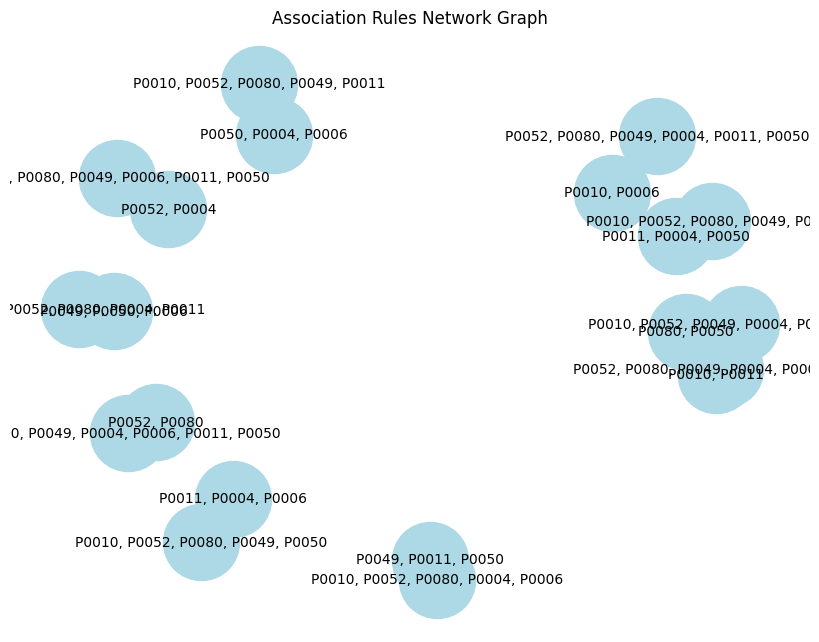

Association rules saved to 'association_rules.csv'


In [ ]:
# Convert transactions into transaction list format
print(" Converting transactions into a transaction list...")
transactions = merged_data.groupby("UserID")["ProductID"].apply(list).tolist()

# Use TransactionEncoder for efficient one-hot encoding
print(" Applying TransactionEncoder...")
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori algorithm with optimized support
print(" Running Apriori algorithm...")
frequent_itemsets = apriori(df_trans, min_support=0.04, use_colnames=True)

# Generate association rules with optimized parameters
print(" Generating association rules...")
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)


# Sort rules by Lift (to prioritize stronger relationships)
rules = rules.sort_values(by="lift", ascending=False)
print(" Association rules generated:")
print(rules[["antecedents", "consequents", "support", "confidence", "lift"]].head())

# 2 Network Graph of Association Rules
print("Visualizing association rules as a network graph")
plt.figure(figsize=(8, 6))
G = nx.DiGraph()

# Add nodes and edges from the top 10 strongest rules
for _, row in rules.nlargest(10, "lift").iterrows():
    antecedents = ", ".join(row["antecedents"])
    consequents = ", ".join(row["consequents"])
    G.add_edge(antecedents, consequents, weight=row["lift"])

# Draw the graph
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)

nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color="gray", font_size=10)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Association Rules Network Graph")
plt.show()
# export to csv
rules.to_csv("association_rules.csv", index=False)
print("Association rules saved to 'association_rules.csv'")

## 📊 Part 4: Visualization
Steps:
- Plot user similarity heatmap
- Plot top frequent itemsets
- Visualize top recommendations

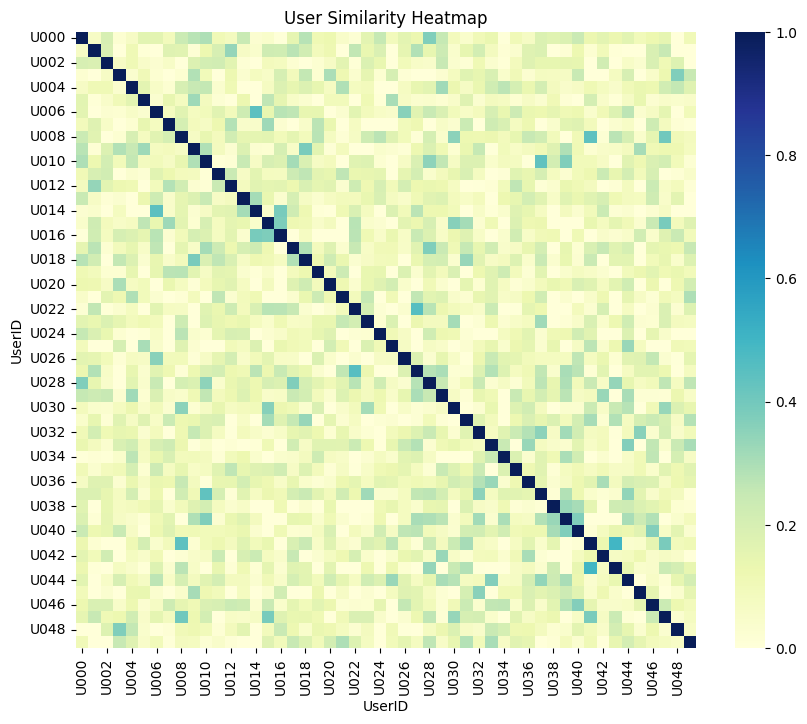

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='YlGnBu')
plt.title('User Similarity Heatmap')
plt.show()

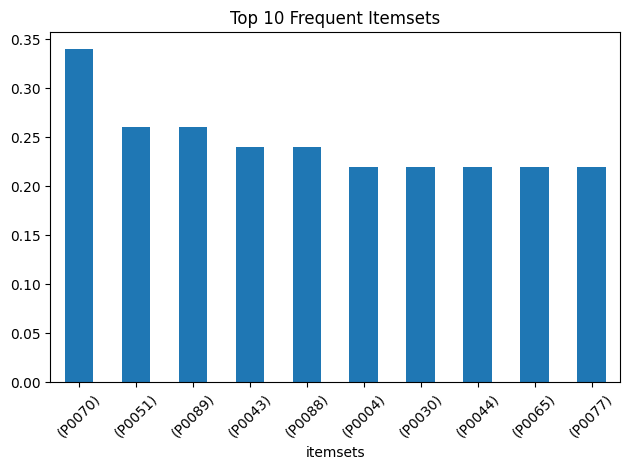

In [ ]:
# Frequent itemsets bar chart
frequent_itemsets.nlargest(10, 'support').plot(kind='bar', x='itemsets', y='support', legend=False)
plt.title('Top 10 Frequent Itemsets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Showing the new bundles introduced by associationg rule

In [ ]:
rules= pd.DataFrame(rules)
product_table= pd.DataFrame(product_data)

# Create a dictionary for ProductID to category mapping
product_dict = dict(zip(product_table['ProductID'], product_table['Category']))

# Function to map ProductID sets to category sets
def map_to_category(product_set):
    return {product_dict.get(ProductID, "Unknown") for ProductID in product_set}

# Apply the mapping function to the antecedents and consequents columns
rules['antecedent_categories'] = rules['antecedents'].apply(lambda x: map_to_category(x))
rules['consequent_categories'] = rules['consequents'].apply(lambda x: map_to_category(x))

# Print the updated rules with categories
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Adjust width for better fit
pd.set_option('display.max_colwidth', None)  # Prevent truncating column data

# Print the updated association rules with categories in table format
print("Updated association rules with category bundles:")
print(rules[["antecedents", "antecedent_categories", "consequents", "consequent_categories"]].head())

# Save updated rules with categories
rules[["antecedents", "antecedent_categories", "consequents", "consequent_categories"]].to_excel("/content/association_rules_with_category_bundles.xlsx", index=False)
print("Association rules with category bundles saved to 'association_rules_with_category_bundles.csv'")

Updated association rules with category bundles:
                 antecedents            antecedent_categories  \
26407  (P0011, P0004, P0050)          {Electronics, Clothing}   
26418         (P0052, P0004)             {Electronics, Books}   
26406  (P0050, P0004, P0006)   {Electronics, Clothing, Books}   
26405  (P0011, P0004, P0006)             {Electronics, Books}   
26404  (P0049, P0011, P0050)  {Beauty, Electronics, Clothing}   

                                      consequents                   consequent_categories  
26407         (P0010, P0052, P0080, P0049, P0006)            {Beauty, Electronics, Books}  
26418  (P0010, P0080, P0049, P0006, P0011, P0050)  {Beauty, Electronics, Clothing, Books}  
26406         (P0010, P0052, P0080, P0049, P0011)            {Beauty, Electronics, Books}  
26405         (P0010, P0052, P0080, P0049, P0050)  {Beauty, Electronics, Clothing, Books}  
26404         (P0010, P0052, P0080, P0004, P0006)                    {Electronics, Books}  
Associat

## 🧠 Part 5: Conceptual Questions
Answer the following questions in your report:
1. How does data sparsity affect performance?

(please refer to Report.pdf file)

2. What kinds of product bundles were discovered?

(please refer to Report.pdf file)

3. What improvements would you suggest for real-world deployment?

(please refer to Report.pdf file)